In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Utils.mlutils as mlutils
import pickle

%matplotlib inline

## Lets see AlexNet

Pre-trained network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

[Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/)

[ImageNet](http://www.image-net.org)

(11, 11, 3, 96)


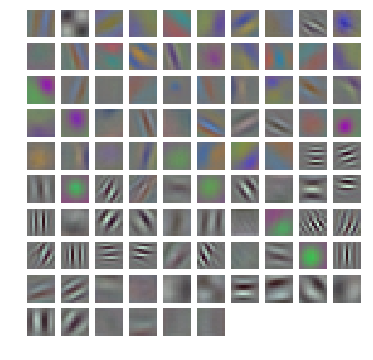

In [2]:
alex_w1 = pickle.load(open('data/alexnet_w1.pkl', 'rb'), encoding='latin1')
print(alex_w1.shape)
mlutils.display_imgs(alex_w1)

### We are going to use them as a starting point for the training of our network

In [3]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [4]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

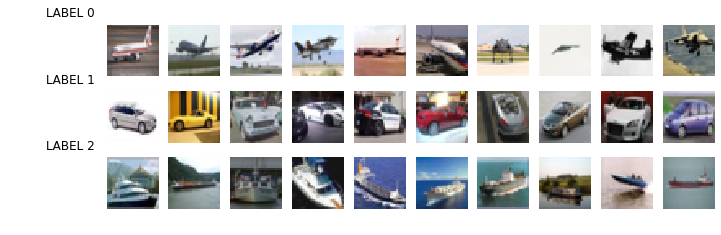

In [5]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    763
0    763
1    727
dtype: int64

distribution of test classes
2    262
1    247
0    242
dtype: int64


In [7]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [8]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [9]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

## Transfer learning!!!

In [10]:
w = model.get_weights()
for i in w:
    print(i.shape)
    

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


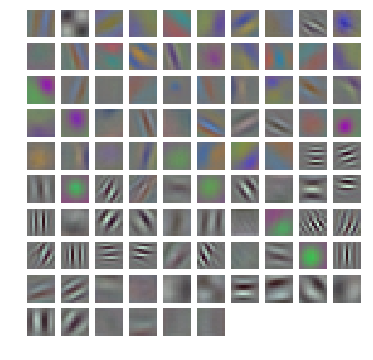

In [11]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [12]:
model.set_weights(w)

In [13]:
train(model, batch_size=32, epochs=10, model_name="model_C")

Train on 2253 samples, validate on 751 samples
Epoch 1/10
2253/2253 [==============================] - 18s 8ms/step - loss: 0.9246 - acc: 0.5570 - val_loss: 0.7407 - val_acc: 0.6658
Epoch 2/10
2253/2253 [==============================] - 17s 8ms/step - loss: 0.6833 - acc: 0.7013 - val_loss: 0.7294 - val_acc: 0.6791
Epoch 3/10
2253/2253 [==============================] - 18s 8ms/step - loss: 0.5833 - acc: 0.7545 - val_loss: 0.6109 - val_acc: 0.7310
Epoch 4/10
2253/2253 [==============================] - 17s 8ms/step - loss: 0.5423 - acc: 0.7776 - val_loss: 0.6139 - val_acc: 0.7337
Epoch 5/10
2253/2253 [==============================] - 19s 8ms/step - loss: 0.5208 - acc: 0.7861 - val_loss: 0.6231 - val_acc: 0.7257
Epoch 6/10
2253/2253 [==============================] - 20s 9ms/step - loss: 0.4507 - acc: 0.8154 - val_loss: 0.5876 - val_acc: 0.7723
Epoch 7/10
2253/2253 [==============================] - 19s 8ms/step - loss: 0.4033 - acc: 0.8336 - val_loss: 0.6569 - val_acc: 0.7443
Epoch 8/

{'loss': 0.7137982991341745, 'acc': 0.766977363832781}

Notes that the first level filters changed, but just a little bit

In [14]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.012235456

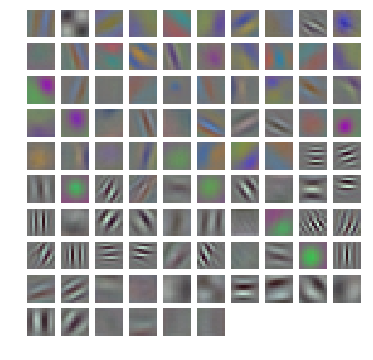

In [15]:
mlutils.display_imgs(w[0])

# "Real" word transfer learning!

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'data/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.63993746), ('n01871265', 'tusker', 0.32709628), ('n02504013', 'Indian_elephant', 0.032862823)]


### ! WOW

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

# Real example!

In [18]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from skimage.transform import resize

In [19]:
NUM_CLASSES = 10
BATCH_SIZE = 32
NUM_EPOCHS = 15
use_data_aug = True
TRAIN_SIZE = 1000
TEST_SIZE = 100

In [20]:
# img_arr is of shape (n, h, w, c)
def resize_image_arr(img_arr):
    x_resized_list = []
    for i in range(img_arr.shape[0]):
        img = img_arr[0]
        resized_img = resize(img, (224, 224))
        x_resized_list.append(resized_img)
    return np.stack(x_resized_list)

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:TRAIN_SIZE]
y_train = y_train[:TRAIN_SIZE]
x_test = x_test[:TEST_SIZE]
y_test = y_test[:TEST_SIZE]

In [22]:
# Resize image arrays
x_train = resize_image_arr(x_train)
x_test = resize_image_arr(x_test)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [23]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [24]:
# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [25]:
base_model = ResNet50(include_top=False, weights='imagenet')

In [26]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer -- 10 classes for CIFAR10
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [27]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
# initiate Adam optimizer
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format("transfer", time()))

In [30]:
if not use_data_aug:
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=False,
              callbacks=[tensorboard])
else:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=BATCH_SIZE),
                        epochs=NUM_EPOCHS,
                        validation_data=(x_test, y_test),
                        workers=1,
                        callbacks=[tensorboard])

Epoch 1/15
32/32 [==============================] - 1466s 46s/step - loss: 0.3361 - acc: 0.9000 - val_loss: 1.5170 - val_acc: 0.8200
Epoch 2/15
32/32 [==============================] - 1397s 44s/step - loss: 0.3282 - acc: 0.9000 - val_loss: 0.3278 - val_acc: 0.9000
Epoch 3/15
32/32 [==============================] - 1404s 44s/step - loss: 0.3272 - acc: 0.9000 - val_loss: 0.3247 - val_acc: 0.9000
Epoch 4/15
32/32 [==============================] - 1408s 44s/step - loss: 0.3257 - acc: 0.9000 - val_loss: 0.3249 - val_acc: 0.9000
Epoch 5/15
32/32 [==============================] - 1408s 44s/step - loss: 0.3259 - acc: 0.9000 - val_loss: 0.3248 - val_acc: 0.9000
Epoch 6/15
32/32 [==============================] - 1409s 44s/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3247 - val_acc: 0.9000
Epoch 7/15
32/32 [==============================] - 1413s 44s/step - loss: 0.3252 - acc: 0.9000 - val_loss: 0.3248 - val_acc: 0.9000
Epoch 8/15
32/32 [==============================] - 1411s 44s/step - 

KeyboardInterrupt: 